# Ackerman and Marley Cloud Model

Here, we try to compute a cloud opacity using Ackerman and Marley Model.
We consider enstatite (MgSiO3) and Fe clouds.  


In [2]:
from exojax.atm import amclouds
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from exojax.spec import rtransfer as rt
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP,logPtop=-8.,logPbtm=4.0)
alpha=0.097
T0=1200.
Tarr=T0*(Parr)**alpha
from exojax.utils.constants import kB,m_u
R=kB/(2*m_u)
rho=Parr/(R*Tarr)

The solar abundance can be obtained using utils.zsol.nsol.

In [44]:
from exojax.utils.zsol import nsol
n=nsol() #solar abundance
VMR_enstatite=np.min([n["Mg"],n["Si"],n["O"]/3])
VMR_Fe=n["Fe"]

Vapor saturation pressures are given in atm.psat

In [50]:
from exojax.atm.psat import Psat_enstatite_AM01, Psat_Fe_solid

P_enstatite=Psat_enstatite_AM01(Tarr)
P_fe_sol=Psat_Fe_solid(Tarr)

Compute a cloud base pressure

In [51]:
from exojax.atm.amclouds import get_Pbase
Pbase_enstatite=get_Pbase(Parr,P_enstatite,VMR_enstatite)
Pbase_Fe_sol=get_Pbase(Parr,P_fe_sol,VMR_Fe)

The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

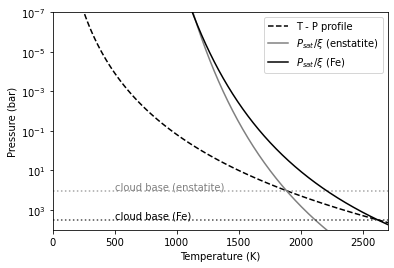

In [70]:
import matplotlib.pyplot as plt
plt.plot(Tarr,Parr,color="black",ls="dashed",label="T - P profile")
plt.plot(Tarr,P_enstatite/VMR_enstatite,label="$P_{sat}/\\xi$ (enstatite)",color="gray")
plt.axhline(Pbase_enstatite,color="gray",alpha=0.7,ls="dotted")
plt.text(500,Pbase_enstatite*0.8,"cloud base (enstatite)",color="gray")

plt.plot(Tarr,P_fe_sol/VMR_Fe,label="$P_{sat}/\\xi$ (Fe)",color="black")
plt.axhline(Pbase_Fe_sol,color="black",alpha=0.7,ls="dotted")
plt.text(500,Pbase_Fe_sol*0.8,"cloud base (Fe)",color="black")

plt.yscale("log")
plt.ylim(1.e-7,10000)
plt.xlim(0,2700)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute VMRs of clouds.

In [66]:
from jax import vmap
from exojax.atm.amclouds import VMRcloud

get_VMRc=vmap(VMRcloud,(0,None,None,None),0)

fsed=3
VMRbase_enstatite=VMR_enstatite
VMRc_enstatite=get_VMRc(Parr,Pbase_enstatite,fsed,VMR_enstatite)

VMRbase_Fe=VMR_Fe
VMRc_Fe=get_VMRc(Parr,Pbase_Fe_sol,fsed,VMR_Fe)

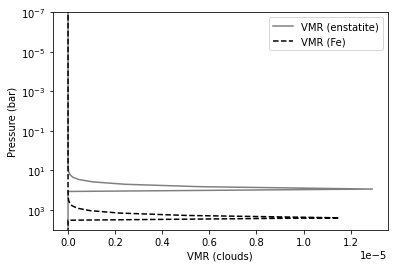

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3,3])
plt.plot(VMRc_enstatite,Parr,color="gray",label="VMR (enstatite)")
plt.plot(VMRc_Fe,Parr,color="black",ls="dashed",label="VMR (Fe)")

plt.yscale("log")
plt.ylim(1.e-7,10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("VMR (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("vmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute dynamic viscosity in H2 atmosphere (cm/g/s)

In [56]:
from exojax.atm.viscosity import eta_Rosner,calc_vfactor
T=np.logspace(np.log10(1000),np.log10(2000))
vfactor,Tr=calc_vfactor("H2")
eta=eta_Rosner(T,vfactor)

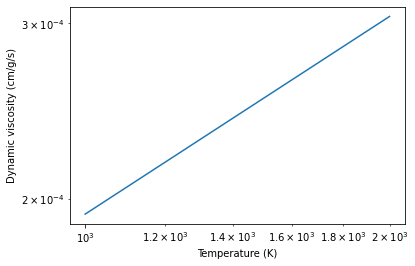

In [57]:
plt.plot(T,eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [60]:
from exojax.atm.atmprof import Hatm
T=1000 #K
mu=2 #mean molecular weight
print("scale height=",Hatm(1.e5,T,mu),"cm")

scale height= 415722.9931793715 cm


In [14]:
rhoc_enstatite=3.192 #g/cm3 Lodders and Fegley (1998)
rhoc_Fe=7.875

from exojax.spec.molinfo import molmass
mu=molmass("H2")
muc_enstatite=molmass("MgSiO3")
muc_Fe=molmass("Fe")

In [86]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import vf
from jax import vmap


vfactor, trange=calc_vfactor(atm="H2")
g=1.e5
rarr=jnp.logspace(-6,-4,2000) #cm
drho=rhoc_enstatite-rho
eta_fid=eta_Rosner(Tarr,vfactor)

vf_vmap=vmap(vf,(None,None,0,0,0))

vfs=vf_vmap(rarr,g,eta_fid,drho,rho)
Kzz=1.e5 #cm2/s
sigmag=2.0
alphav=1.3
mu=2.0
L=Hatm(g,1500,mu)

In [87]:
Kzz/L

0.160363193184992

Text(0.5, 0, 'condensate size (cm)')

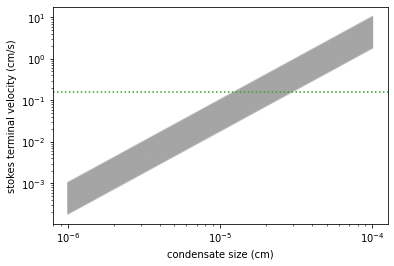

In [88]:
for i in range(0,len(Tarr)):
    plt.plot(rarr,vfs[i,:],alpha=0.2,color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz/L,label="Kzz/H",color="C2",ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

In [89]:
def find_rw(vfs_each,Kzz,L,rarr):
    iscale=jnp.searchsorted(vfs_each,Kzz/L)
    rw=rarr[iscale]
    return rw
   
vfind_rw=vmap(find_rw,(0,None,None,None),0)

In [90]:
rw=vfind_rw(vfs,Kzz,L,rarr)

In [91]:
def get_rg(rw,fsed,alpha,sigmag):
    
    rg=rw*fsed**(1.0/alpha)*jnp.exp(-(alpha/2.0+3.0)*(jnp.log(sigmag))**2)
    return rg
    

In [92]:
rg=get_rg(rw,fsed,alphav,sigmag)

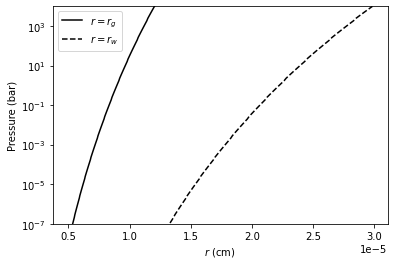

In [102]:
plt.plot(rg,Parr,label="$r=r_g$",color="black")
plt.plot(rw,Parr,ls="dashed",label="$r=r_w$",color="black")
plt.ylim(1.e-7,10000)
plt.xlabel("$r$ (cm)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.legend()

In [103]:
def dtau_cloudgeo(Parr,muc,rhoc,mu,VMRc,rg,sigmag,g):
    fac=jnp.exp(-2.5*jnp.log(sigmag)**2)
    dtau=1.5*muc/mu*VMRc*fac/(rg*rhoc*g)*Parr*1.e6
    return dtau

In [104]:
dtau_enstatite=dtau_cloudgeo(Parr,muc_enstatite,rhoc_enstatite,mu,VMRc_enstatite,rg,sigmag,g)
dtau_Fe=dtau_cloudgeo(Parr,muc_Fe,rhoc_Fe,mu,VMRc_Fe,rg,sigmag,g)

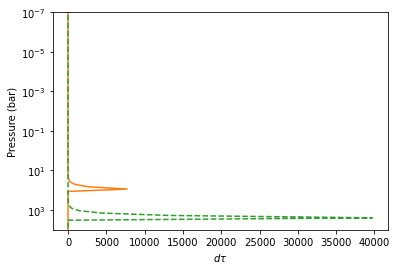

In [105]:
plt.plot(dtau_enstatite,Parr,color="C1")
plt.plot(dtau_Fe,Parr,color="C2",ls="dashed")
plt.yscale("log")
plt.ylim(1.e-7,10000)
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

In [106]:
#CIA
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(9500,30000,1000,unit="AA")
from exojax.spec import contdb
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

nugrid is log: mode= lpf
H2-H2


In [107]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

In [108]:
dtau=dtaucH2H2+dtau_enstatite[:,None]+dtau_Fe[:,None]

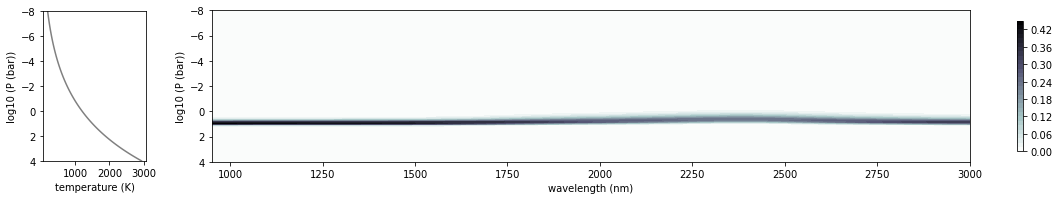

In [109]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr,unit="nm")
plt.show()

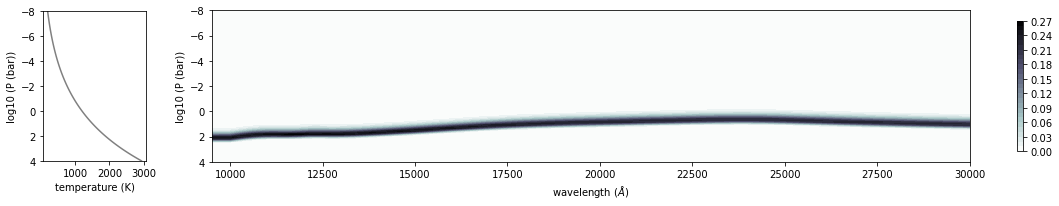

In [110]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtaucH2H2,Tarr,Parr,dParr,unit="AA")
plt.show()

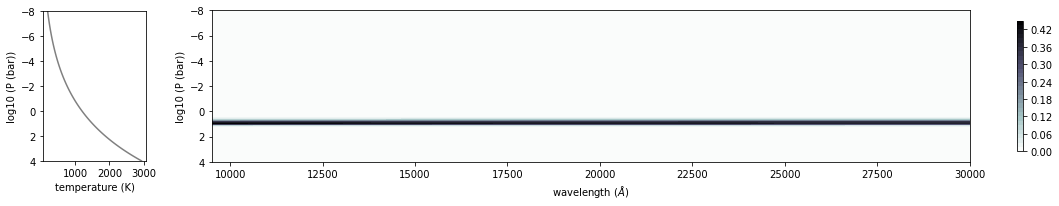

In [111]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau_enstatite[:,None]+np.zeros_like(dtaucH2H2),Tarr,Parr,dParr,unit="AA")
plt.show()

In [112]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F0CIA=rtrun(dtaucH2H2,sourcef)
F0cl=rtrun(dtau_enstatite[:,None]+np.zeros_like(dtaucH2H2),sourcef)

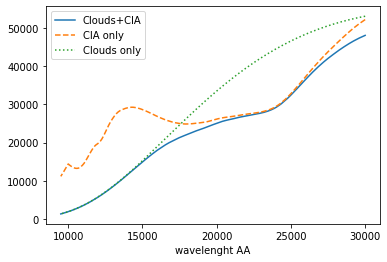

In [113]:
plt.plot(wav[::-1],F0,label="Clouds+CIA")
plt.plot(wav[::-1],F0CIA,label="CIA only",ls="dashed")
plt.plot(wav[::-1],F0cl,label="Clouds only",ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()